Date
2018-03-26 00:00:00-04:00    2658.550049
2018-03-27 00:00:00-04:00    2612.620117
2018-03-28 00:00:00-04:00    2605.000000
2018-03-29 00:00:00-04:00    2640.870117
2018-04-02 00:00:00-04:00    2581.879883
                                ...     
2023-03-20 00:00:00-04:00    3951.570068
2023-03-21 00:00:00-04:00    4002.870117
2023-03-22 00:00:00-04:00    3936.969971
2023-03-23 00:00:00-04:00    3948.719971
2023-03-24 00:00:00-04:00    3970.989990
Name: Close, Length: 1259, dtype: float64


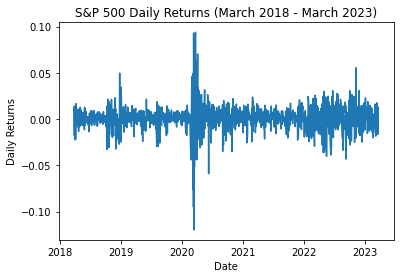

In [1]:
#import libraries
#yfinance library is used to import stock data
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#Index: S&P500 - start date, and end date
symbol = "^GSPC"
start_date = "2018-03-26"
end_date = "2023-03-25"

#get historical data for the specified symbol and time frame
ticker = yf.Ticker(symbol)

data = ticker.history(start=start_date, end=end_date, interval="1d", auto_adjust=True)

# print the closing price of the stock for each day in the specified time frame
print(data["Close"])

# calculate the daily returns 
#as the percent change in daily closing prices
data["returns"] = data["Close"].pct_change()

# plot a line chart of the daily percent returns
plt.plot(data.index, data["returns"])
plt.xlabel("Date")
plt.ylabel("Daily Returns")
plt.title("S&P 500 Daily Returns (March 2018 - March 2023)")
plt.show()


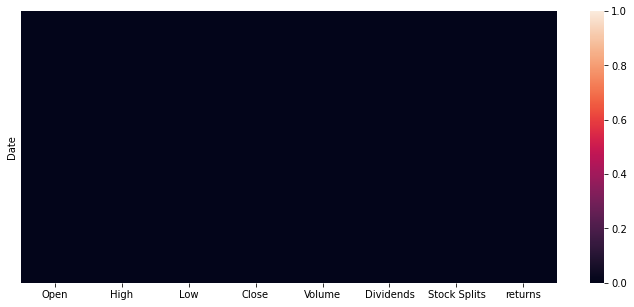

              THERE ARE NO MISSING VALUES IN THIS DATASET


The closing values of S&P500 each day: [2658.55004883 2612.62011719 2605.         ... 3936.9699707  3948.7199707
 3970.98999023]

Shape of close_values (1259,)

Length of closing values of S&P500 dataset: 1259


In [2]:
import seaborn as sns

#using a heatmap to look for any missing values within our dataset
plt.figure(figsize=(12,5))
sns.heatmap(data.isnull(),yticklabels=False)
plt.show()
print("              THERE ARE NO MISSING VALUES IN THIS DATASET\n\n")

close_values = data["Close"].values

print("The closing values of S&P500 each day:",close_values)

print("\nShape of close_values",close_values.shape)

print("\nLength of closing values of S&P500 dataset:",len(close_values))

In [3]:
#assigning values
x_minmax = close_values
x_meanstd = close_values

#assigning maximum and minimum
ymin = np.min(x_minmax)
ymax = np.max(x_minmax)

#min-max scaling to normalise the dataset
close_values_minmax = 2*((x_minmax-ymin)/(ymax-ymin)-0.5)

print("Values after Min-Max Scaling",close_values_minmax)

#compute mean and standard deviation
#and assign to variables
ymean = np.mean(x_meanstd)
ystd = np.std(x_meanstd)

#z-normalisation using mean and std of the dataset
#multiplying by 0.5 to make the values even smaller 
#inorder to achieve better model-fit
close_values_meanstd = ((x_meanstd-ymean)/ystd)*0.5

print("\n\nValues after z-normalisation",close_values_meanstd)
print("\nThe shape of close_values_meanstd:",close_values_meanstd.shape,"\n")


Values after Min-Max Scaling [-0.67086847 -0.70676301 -0.71271818 ...  0.32822486  0.33740756
  0.35481172]


Values after z-normalisation [-0.64303497 -0.67786022 -0.68363798 ...  0.32629564  0.33520479
  0.35209049]

The shape of close_values_meanstd: (1259,) 



In [4]:
#transforming the matrix to generate lags in the dataset
lagArray = close_values_meanstd.reshape(-1,1)
print("The shape of lagArray:",lagArray.shape,"\n")


#input dimension/window size for which-- 
#--one-step ahead prediction needs to be done on dataset
inputDim = 10

#output dimension
outputDim = len(lagArray) - inputDim 
#print("The value of outputDim:",outputDim,"\n")

#intitialising x1 matrix to zeros
x1 = np.zeros((outputDim,inputDim))

#intitialising y1 to zero
y1 = np.zeros(outputDim)

#for-loop to find x1 and y1 values according to input dimension
#to enable one step ahead prediction
for i in range(1, outputDim):
    
    y1[i] = lagArray[i + inputDim]
    
    for j in range(0,inputDim):
        x1[i, j] = lagArray[i-j+inputDim]
        
    #print(round(y1[i],5))

#Choosing the x1 and y1 values that fit perfectly
y1 = y1[2:(outputDim)]
x1 = x1[1:(outputDim-1)]


print("y1:\n",y1, "\n\n")
print("x1:\n",x1, "\n")

print("The shape of x1:",x1.shape,"\n")
print("The shape of y1:",y1.shape,"\n")

The shape of lagArray: (1259, 1) 

y1:
 [-0.63891027 -0.64474098 -0.62840877 ...  0.32629564  0.33520479
  0.35209049] 


x1:
 [[-0.65543962 -0.64430874 -0.67745093 ... -0.70116825 -0.65644034
  -0.68363798]
 [-0.63891027 -0.65543962 -0.64430874 ... -0.67647279 -0.70116825
  -0.65644034]
 [-0.64474098 -0.63891027 -0.65543962 ... -0.65354406 -0.67647279
  -0.70116825]
 ...
 [ 0.37626281  0.33736581  0.31088085 ...  0.26914069  0.31215481
   0.3680284 ]
 [ 0.32629564  0.37626281  0.33736581 ...  0.26472017  0.26914069
   0.31215481]
 [ 0.33520479  0.32629564  0.37626281 ...  0.31289026  0.26472017
   0.26914069]] 

The shape of x1: (1247, 10) 

The shape of y1: (1247,) 



In [11]:
#Train Set and Test-Set
x = close_values
print("Print the length of x1:",len(x1))

#setting parameters to split the data into train and test set
train_close_values = round(len(x)*0.75)
print("Train:",train_close_values)

test_close_values = round(len(x)*0.25)
print("\nTest:",test_close_values)

#training set x values
x = x1[0:(outputDim-test_close_values), 0:10]
print("\nArray x:","\n",x)
print("\nThe shape of x:",x.shape,"\n")

#training set y values
y = y1[0:(outputDim-test_close_values)]
print("\nThe shape of y:",y.shape,"\n")
print("\nArray y:","\n",y)


#test set x values
t = x1[train_close_values:(outputDim-2), 0:10]
print("\nShape of target test values matrix t:",t.shape)

#test set y values
y_test = y1[train_close_values:outputDim]
print("\nShape of target test values matrix y_test:",y_test.shape)


# transpose the array x to create the array newArray
newArray = np.transpose(x)

# print the shape of newArray and arrays x and y
print("The shape of newArray:", newArray.shape)

#assign y values to variable targets
targets = y

#print the shape of newArray
print('targets shape:', targets.shape)

#initialize variables NHIDDENS and outputVal
NHIDDENS = 5
outputVal = targets

#initialize variables NINPUTS and NPATS
NINPUTS, NPATS = newArray.shape

#print the values of variables NINPUTS and NPATS
print("Value of NINPUTS:", NINPUTS, "\nValue of NPATS:", NPATS)

#initialize variables NP and NOUTPUTS
NP = targets.shape[0]
NOUTPUTS = targets.shape[0]/NP

#print the values of variables NP and NOUTPUTS
print("Value of NP:", NP, "\nValue of NOUTPUTS:", NOUTPUTS)


Print the length of x1: 1247
Train: 944

Test: 315

Array x: 
 [[-0.65543962 -0.64430874 -0.67745093 ... -0.70116825 -0.65644034
  -0.68363798]
 [-0.63891027 -0.65543962 -0.64430874 ... -0.67647279 -0.70116825
  -0.65644034]
 [-0.64474098 -0.63891027 -0.65543962 ... -0.65354406 -0.67647279
  -0.70116825]
 ...
 [ 0.80477389  0.84467181  0.88108921 ...  0.88016439  0.9057619
   0.89479799]
 [ 0.86634935  0.80477389  0.84467181 ...  0.91395836  0.88016439
   0.9057619 ]
 [ 0.90223623  0.86634935  0.80477389 ...  0.8813169   0.91395836
   0.88016439]]

The shape of x: (934, 10) 


The shape of y: (934,) 


Array y: 
 [-0.63891027 -0.64474098 -0.62840877 -0.60676158 -0.60505557 -0.61681566
 -0.63424725 -0.63413341 -0.66122479 -0.6575551  -0.63667354 -0.63442163
 -0.65099634 -0.64587832 -0.66038327 -0.66488708 -0.63934251 -0.63235928
 -0.63289759 -0.61328221 -0.59411424 -0.59058857 -0.58876131 -0.60292491
 -0.59457684 -0.59634357 -0.6017724  -0.58657753 -0.59307557 -0.5863652
 -0.59055821 -0

The shape of input matrix: (11, 934)
Test runs 0: Epoch 0: Error = 222.9182578108521
Test runs 0: Epoch 1: Error = 55.198627370792806
Test runs 0: Epoch 2: Error = 12.3044978066908
Test runs 0: Epoch 3: Error = 3.277613535867067
Test runs 0: Epoch 4: Error = 2.20426965857387
Test runs 0: Epoch 5: Error = 2.1018038737913405
Test runs 0: Epoch 6: Error = 2.083529705525976
Test runs 0: Epoch 7: Error = 2.0732233115937486
Test runs 0: Epoch 8: Error = 2.064096102339139
Test runs 0: Epoch 9: Error = 2.055305380336014
Test runs 0: Epoch 10: Error = 2.046680458092568
Test runs 0: Epoch 11: Error = 2.038170340472308
Test runs 0: Epoch 12: Error = 2.0297591207821597
Test runs 0: Epoch 13: Error = 2.021440061635225
Test runs 0: Epoch 14: Error = 2.0132102701371886
Test runs 0: Epoch 15: Error = 2.0050676007288146
Test runs 0: Epoch 16: Error = 1.9970104622220384
Test runs 0: Epoch 17: Error = 1.9890373011256681
Test runs 0: Epoch 18: Error = 1.981146692339907
Test runs 0: Epoch 19: Error = 1.973

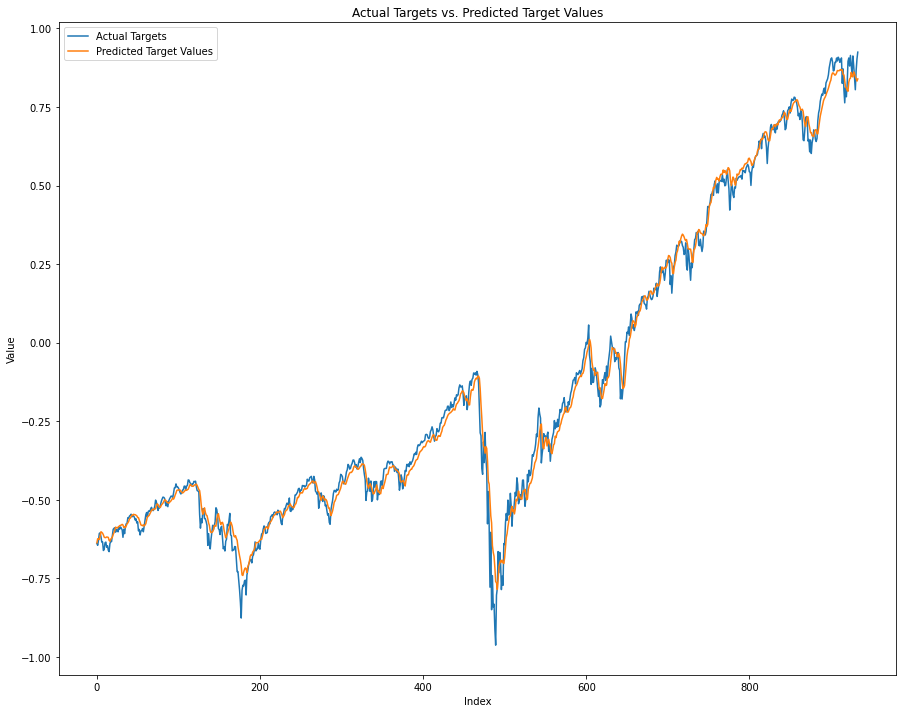

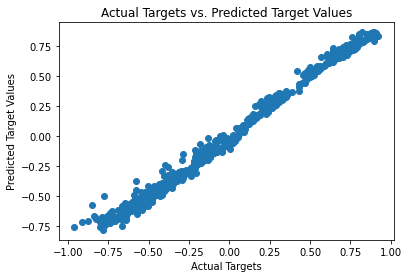

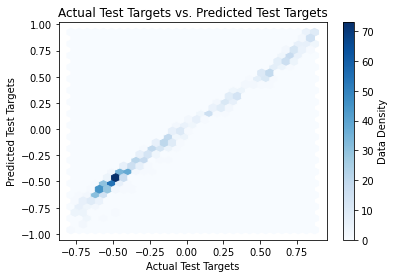

In [12]:
import scipy.io as sio

eta = 0.001
#target error
L = 0.02

# set the number of epochs
epochs = 100


# initialize the best SSE to infinity
best_sse = np.inf

#initialis
weights1 =[]
weights2 =[]

#make input matrix
inputs = np.concatenate((newArray, np.ones((1, NPATS))), axis=0)
print("The shape of input matrix:", inputs.shape)

for i in range (1):
    
    #using the random seed function
    #find best weights corresponding to each test run
    np.random.seed(53)
    
    #weight matrix w1 & w2
    w1 = 0.5 * (np.random.rand(NHIDDENS, NINPUTS+1) - 0.5)
    w2 = 0.5 * (np.random.rand(1, NHIDDENS+1) - 0.5) 
     
          
    for epoch in range(epochs):
        
        w1_copy = np.copy(w1)
        w2_copy = np.copy(w2)
        
        # Forward propagation
        sum1 = np.matmul(w1_copy, inputs) 
        
        #finding hidden node value by calculating tanh of the output
        hidden = np.tanh(sum1)
        
        #calculating dot product and output node
        #adding a bias term to the hidden node using concatenate before using dot product
        sum2 = np.dot(w2_copy, np.concatenate((hidden, np.ones((1, NPATS))), axis=0))
        
        #assigning vlaues to variables to use later
        out = sum2 
        outputVal = out
        
        #Backpropagation of errors
        error = targets - out 
        sse = np.sum(np.sum((error**2)))
        bout = error 
        bp = np.dot(w2.T, bout) 
        bh = np.multiply((1.0 - np.power(hidden, 2)), bp[:-1, :])
        
        # Computing the change in weights:
        dW2 = np.dot(bout, np.concatenate((hidden, np.ones((1, NPATS))), axis=0).T)
        dW1 = np.dot(bh, inputs.T)
            
        # Updating the weights:
        w2 = w2_copy + eta*dW2
        w1 = w1_copy + eta*dW1
        
        #store the best sse to find the best weights 
        if sse < best_sse:
            best_sse = sse
            best_weights = (w1_copy, w2_copy)
            
        # print the SSE for this test run
        print(f'Test runs {i}: Epoch {epoch}: Error = {sse}')
    
    
print("\n\n",f'Best SSE = {best_sse}',"\n")
print(f'Best weights:',"\n")
print(f'w1 = {best_weights[0]}',"\n\n")
print(f'w2 = {best_weights[1]}')
print("The shape of W1 weight matrix:", w1.shape)
print("The shape of W2 weight matrix:", w2.shape)


# Forward propagation using the best weights
#sum1_best = np.matmul(w1, inputs)
#hidden_best = np.tanh(sum1_best)
#sum2_best = np.dot(w2, np.concatenate((hidden_best, np.ones((1, NPATS))), axis=0))
predictions = outputVal


# Flatten the predictions array to 1D to plot using Matplotlib
flat_predictions = predictions.ravel()

# Create a line plot for both actual targets and predicted targets
plt.figure(figsize=(15,12))
plt.plot(targets, label='Actual Targets')
plt.plot(flat_predictions, label='Predicted Target Values')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Actual Targets vs. Predicted Target Values')
plt.legend()
plt.show()

#Scatter Plot
plt.title('Actual Targets vs. Predicted Target Values')
plt.scatter(targets, flat_predictions)
plt.xlabel('Actual Targets')
plt.ylabel('Predicted Target Values')
plt.show()

# Create a hexbin plot
plt.hexbin(flat_predictions, targets, gridsize=30, cmap='Blues')
plt.xlabel('Actual Test Targets')
plt.ylabel('Predicted Test Targets')
plt.title('Actual Test Targets vs. Predicted Test Targets')
plt.colorbar(label='Data Density')
plt.show()

(11, 303)
(5, 303)
(1, 303)
Shape of outputVal: (1, 303)
Shape of predictions: (303,)


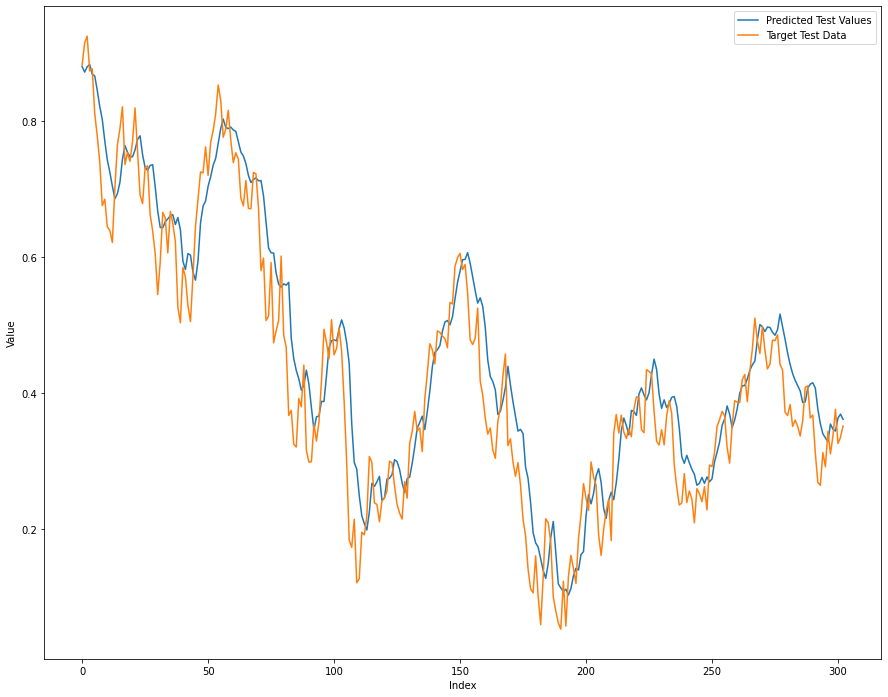

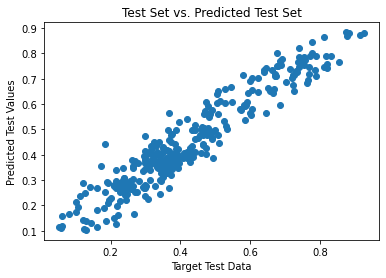

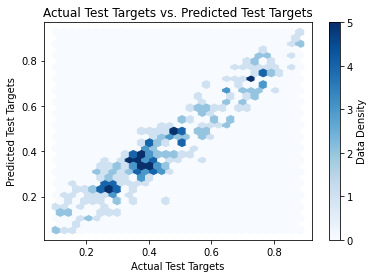

In [13]:
#Forecast the data

testinputs = np.concatenate((t.T, np.ones((1, t.shape[0]))), axis=0)
print(testinputs.shape)
sum1 = np.matmul(w1, testinputs) 
print(sum1.shape)
hidden = np.tanh(sum1)
sum2 = np.dot(w2, np.concatenate((hidden, np.ones((1, t.shape[0]))), axis=0))
print(sum2.shape)
out = sum2 
outputVal = out
print("Shape of outputVal:",outputVal.shape)

#Flatten outputVal dataset to 1DArray to visualize the data
predictions = outputVal.ravel()
print("Shape of predictions:",predictions.shape)

#Plot graph
plt.figure(figsize=(15,12))
plt.plot(range(len(predictions)), predictions, label='Predicted Test Values')
plt.plot(range(len(y_test)), y_test, label='Target Test Data')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.show()

#Scatter Plot
plt.title('Test Set vs. Predicted Test Set')
plt.scatter(y_test, predictions)
plt.xlabel('Target Test Data')
plt.ylabel('Predicted Test Values')
plt.show()


# Create a hexbin plot
plt.hexbin(predictions, y_test, gridsize=30, cmap='Blues')
plt.xlabel('Actual Test Targets')
plt.ylabel('Predicted Test Targets')
plt.title('Actual Test Targets vs. Predicted Test Targets')
plt.colorbar(label='Data Density')
plt.show()
